In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.rcParams.update({
    'figure.figsize': (3.6, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'legend.fontsize': 'small', 'axes.titlesize': 'medium',
    'axes.spines.top': False, 'axes.spines.right': False,
    'image.interpolation': 'nearest', 'savefig.dpi': 100,
})

import os
import pickle
from pathlib import Path
import numpy as np
from jarvis.utils import tqdm

from hexarena import STORE_DIR
FIG_DIR = Path('figures')
os.makedirs(FIG_DIR, exist_ok=True)
rng = np.random.default_rng()

# Overview of data

In [2]:
from hexarena.utils import load_monkey_data, align_monkey_data
from hexarena.scripts.common import get_block_ids, create_env

env = create_env(1., env_kw={'arena': {'resol': 4}})

In [3]:
save_pth = STORE_DIR/'behavior.overview.pkl'
if os.path.exists(save_pth):
    with open(save_pth, 'rb') as f:
        saved = pickle.load(f)
    summaries = saved['summaries']
else:
    kappas = {
        'marco': [0.01, 0.1], 'dylan': [0.01, 0.1], 'viktor': [0.02, 0.04, 0.08, 0.1],
    }
    summaries = {}
    for subject in kappas:
        block_ids = []
        for kappa in kappas[subject]:
            block_ids += get_block_ids(subject, kappa, min_pos_ratio=0.05, min_gaze_ratio=0)
        occupancy = np.zeros((2, env.arena.num_tiles))
        num_steps = 0
        pushes = np.zeros(3)
        for session_id, block_idx in tqdm(block_ids, desc=subject, unit='block'):
            block_data = load_monkey_data(subject, session_id, block_idx)
            for i in range(2):
                if i==1:
                    align_monkey_data(block_data)
                env_data = env.convert_experiment_data(block_data)
                push = np.concatenate([[False], env_data['push']])
                vals = env_data['pos'][~push]
                occupancy[i] += np.histogram(vals, np.arange(env.arena.num_tiles+1)-0.5)[0]
            num_steps += env_data['num_steps']
            pushes += np.histogram(env_data['box_idx'][env_data['push']], np.arange(4)-0.5)[0]
        summaries[subject] = {
            'occupancy': occupancy, 'num_steps': num_steps, 'pushes': pushes,
        }
    with open(save_pth, 'wb') as f:
        pickle.dump({'summaries': summaries}, f)

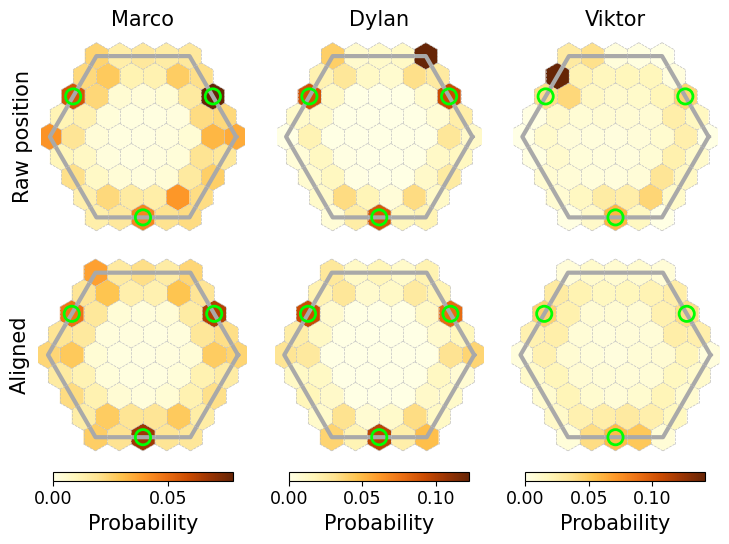

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6), height_ratios=[1, 1.2], gridspec_kw={'hspace': 0.05, 'wspace': 0.05})
for j, subject in enumerate(summaries):
    occupancy = summaries[subject]['occupancy']
    probs = occupancy/occupancy.sum(axis=-1, keepdims=True)
    vmax = probs.max()
    for i in range(2):
        ax = axes[i, j]
        env.arena.plot_map(ax, probs[i], vmax=vmax, cbar_kw={'label': 'Probability', 'disable': i==0})
    axes[0, j].set_title(subject.capitalize())
axes[0, 0].text(-1.4, 0, 'Raw position', rotation='vertical', va='center')
axes[1, 0].text(-1.4, 0, 'Aligned', rotation='vertical', va='center')
plt.show()

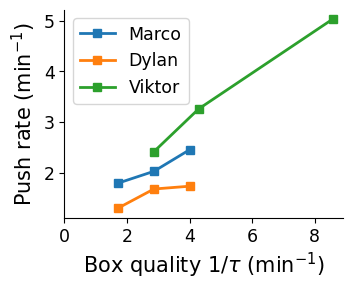

In [5]:
fig, ax = plt.subplots()
taus = {
    'marco': [35, 21, 15], 'dylan': [35, 21, 15], 'viktor': [21, 14, 7],
}
lines, legends = [], []
for subject in summaries:
    push_rates = summaries[subject]['pushes']/summaries[subject]['num_steps']/env.dt*60
    line, = ax.plot(60/np.array(taus[subject]), push_rates, marker='s')
    lines.append(line)
    legends.append(subject.capitalize())
ax.legend(lines, legends)
ax.set_xlim([0, None])
ax.set_xlabel(r'Box quality 1/$\tau$ (min$^{-1}$)')
ax.set_ylabel([0, None])
ax.set_ylabel(r'Push rate (min$^{-1}$)')
plt.show()